In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime

In [8]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import RatingSet
importlib.reload(RatingSet)
import PredictorModel
importlib.reload(PredictorModel)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(Hypers.Config.seed)

In [4]:
model = PredictorModel.PredictorModel(input_size=len(Hypers.feature_list), 
                                      hidden_size=Hypers.Config.hidden_size, 
                                      proj_size=Hypers.Config.proj_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "features_ratings_extended.pkl"))
train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True)
print(len(train_dict), len(test_dict))

47 19


In [9]:
train_set, test_set = RatingSet.RatingSet(merged_dict), RatingSet.RatingSet(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=utils.custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=utils.custom_collate_fn)

trainer = Trainer.Trainer(model, criterion, optimizer, device, train_loader, test_loader)
train_loss, train_accuracy, test_loss, test_accuracy = trainer.train_loop()

Vaild Epoch 999: 100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s, Loss: 0.985]


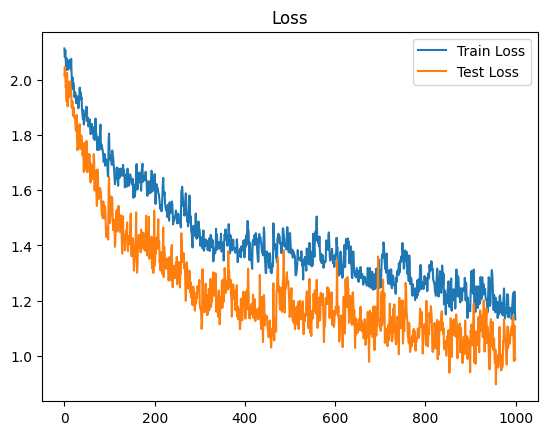

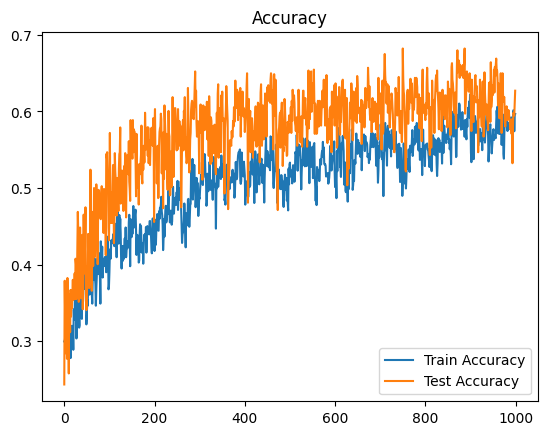

In [10]:
utils.plot_graph(train_loss, train_accuracy, test_loss, test_accuracy)